BART (Bidirectional Encoder Representations from Transformers) is a state-of-the-art neural network model that is commonly used for natural language processing tasks, such as text summarization. It is a type of encoder-decoder model, which means that it takes in a sequence of words as input and then produces a representation of the input text as output.

BART is trained using a technique called masked language modeling, which involves masking (or "blanking out") some of the words in the input text and then training the model to predict the masked words based on the surrounding context. This allows BART to learn rich and nuanced representations of the input text that capture the relationship between words and their meaning thus generating better results.

BLURR is a library designed for fastai developers who want to train and deploy Hugging Face transformers. We have used BLURR to train BART transformer pre-trained model on CNN News Dataset and use it to generate summaries of custom inputs. The following script also generates BERT Score and ROUGE scores for the model. 

References: 

[1] https://huggingface.co/datasets/ccdv/cnn_dailymail - Dataset used for training

[2] https://ohmeow.github.io - BLURR library for training BART transformer

In [ ]:
!pip install ohmeow-blurr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 451 kB 58.0 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 96 kB 7.3 MB/s 
     |████████████████████████████████| 1.3 MB 62.9 MB/s 
     |████████████████████████████████| 5.8 MB 52.1 MB/s 
     |████████████████████████████████| 7.6 MB 53.6 MB/s 
     |████████████████████████████████| 182 kB 78.9 MB/s 
     |████████████████████████████████| 132 kB 81.8 MB/s 
     |████████████████████████████████| 212 kB 79.3 MB/s 
     |████████████████████████████████| 127 kB 76.3 MB/s 
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=5cf4e1c29531a39c6e4407f5a6c4ce9c772be11161c0afe02a2cf9412d3297f4
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
  

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 7.8 MB/s 


In [ ]:
# Importing the required libraries

import os, warnings

import torch
from transformers import *
from transformers.utils import logging as hf_logging
from fastai.text.all import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *
from datasets import load_dataset


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Loading the dataset [Link: https://huggingface.co/datasets/ccdv/cnn_dailymail]
# Here, we only take 2000 rows as training data because training the model with more number of rows causes the model to take longer time to train.
# As a result, due to unavailability of resources, the Google Colab Notebook tends to timeout.

dataset = load_dataset("ccdv/cnn_dailymail", "3.0.0", split="train[:2000]")
df = pd.DataFrame(dataset)
df.head()

,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L

In [ ]:
# Loading the pre-trained BART transformer model and getting its configuration objects and tokenizer.

pretrained_model_name = "sshleifer/distilbart-cnn-6-6"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
# Preprocessing the data
# Here, we have used the preprocessor offered by BLURR for seq2seq models.
# It takes in the column names from the data frame along with the pretrained model's tokenizer,
# maximum input length and the maximum and minimum length of the target summary. 
# As seen below, the data frame gets transformed into a preprocessed data frame which is later used for training.

preprocessor = SummarizationPreprocessor(
    hf_tokenizer,
    id_attr="id",
    text_attr="article",
    target_text_attr="highlights",
    max_input_tok_length=128,
    max_target_tok_length=30,
    min_summary_char_length=10,
)
df = preprocessor.process_df(df)
df.head()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


,proc_highlights,proc_article,article,highlights,id,article_start_char_idx,article_end_char_idx,highlights_start_char_idx,highlights_end_char_idx
0,"Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the","It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01,0,663,0,113
1,Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling","(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef,0,563,0,107
2,"The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.","Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home office

In [ ]:
def generateTextArgs():
  text_gen_kwargs = {}
  if hf_arch in ["bart", "t5"]:
      text_gen_kwargs = {**hf_config.task_specific_params["summarization"], **{"max_length": 50, "min_length": 10}}

  generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())

  # Remove unnecessary function arguments from the dictionary
  for k in text_gen_kwargs.copy():
      if k not in generate_func_args:
          del text_gen_kwargs[k]
  
  return text_gen_kwargs

In [ ]:
# Generate the arguments for summarization
text_gen_kwargs = generateTextArgs()

# Tokenize the data
if hf_arch == "mbart":
    text_gen_kwargs["decoder_start_token_id"] = hf_tokenizer.get_vocab()["en_XX"]
  
tok_kwargs = {}
if hf_arch == "mbart":
    tok_kwargs["src_lang"], tok_kwargs["tgt_lang"] = "en_XX", "en_XX"


# Returns a mini-batch of inputs and targets along with decoding the tokenizer dictionary.
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130,
    tok_kwargs=tok_kwargs,
    text_gen_kwargs=text_gen_kwargs,
)

# Prepares the training blocks
blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)


# Generating data blocks for fast processing and training
data_block = DataBlock(blocks=blocks, get_x=ColReader("article"), get_y=ColReader("highlights"), splitter=RandomSplitter())

In [ ]:
data_loaders = data_block.dataloaders(df, bs=4)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
b = data_loaders.one_batch()

In [ ]:
data_loaders.show_batch(dataloaders=data_loaders, max_n=4)

,text,target
0,"<s> (CNN) -- On the sweltering evening of April 12, 2009, as dusk deepened over the Indian Ocean, several hundred miles off the coast of Somalia, three shots rang out. All the bullets found their targets -- three Somali pirates in a small lifeboat bobbing on the darkening sea. For the past five days the pirates had taken hostage Richard Phillips, the American captain of the Maersk Alabama container ship. President Barack Obama had authorized the use of deadly force if Phillips' life was in danger. Unbeknownst to the pirates, days earlier a contingent from SEAL Team 6 had parachuted at night into the ocean near the USS Bainbridge warship, which was shadowing the pirates in their boat. The SEALs had taken up position on the fantail of the Bainbridge and were carefully monitoring Phillips while he was in the custody of the pirates. One of the pirates had just pointed his AK-47 at the American captain as if he were going to shoot him. That's when the SEAL team commander on the Bainbridge ordered his men to take out the pirates. U.S. terror raids: 2 operations. 2 outcomes. 5 questions. Three U.S. Navy SEAL sharpshooters fired simultaneously at the pirates from</s>","Peter Bergen: After 'Blackhawk Down' disaster, U.S. stopped relying on special forces.\nHe says 9/11 led to renewed interest in using SEALs, other special forces.\nBergen: Weekend's operations show Obama's continued support for special forces.\n2009 rescue of U.S. merchant captain from pirates impressed Obama, he says."
1,"<s> (CNN) -- The generation of gays and lesbians that literally created the modern LGBT movement -- from the heroes of the 1969 Stonewall riots to their slightly younger friends -- is at, or nearing, retirement age. That used to mean the beginning of an extremely difficult time in an LGBT person's life. But as gay baby boomers find more acceptance in mainstream society and continue to do what they've always done -- push to make a better world for the LGBT community -- their retirement options are slowly improving. That is, if they decide to retire at all. ""The notion of retirement has never been a part of my vocabulary,"" said Bob Witeck, CEO and co-founder of Witeck Communications. Nearly 61, Witeck has put some thought into what he should do with his strategic public relations and marketing firm as he gets older. Like many friends his age who are also entrepreneurs, he plans to keep working. ""Because I run a business, as I get older I can change the intensity of my engagement in the kinds of work I take on,"" Witeck said. ""I know I'm lucky that way, and I'm lucky in my personal life as well. My husband is 50, so I have a younger man to help me</s>","LGBT baby boomers changed the visibility of the gay community.\nAs they approach retirement, they face different obstacles than their straight counterparts.\nWithout marriage equality, same-sex couples may face financial hardships.\nAdvocates say the situation is slowly improving."
2,"<s> Four decades before anyone took an arrow to the knee in ""Skyrim,"" adventurers were sitting down with paper and pencil to battle fantasy monsters and explore rich, new worlds in a different kind of role-playing game. ""Dungeons & Dragons,"" commonly known simply as D&D, burst onto the scene in 1974, long before the word ""gaming"" came with the implied word ""video"" in front of it. In D&D, the brainchild of creators Gary Gygax and Dave Arneson, players could become fighters, magic-users, and clerics, and run through adventures created by a ""Dungeon Master"" or ""DM"" -- the person responsible for controlling nearly every aspect of the game. Players sat around a table rolling multi-sided dice and visualizing the adventure using just their imaginations -- a far cry from today's vast, richly rendered video-game worlds. But four decades later, and with all its high-tech competition, ""Dungeons & Dragons"" continues to grow and evolve. And many of today's computer games, animated television shows, featu

In [ ]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
}

In [ ]:
# Get the model and learning metrics which include ROUGE and BERT Score

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
metrics = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    data_loaders,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# learn = learn.to_native_fp16() #.to_fp16()
learn.freeze()

In [ ]:
learn.summary()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


BaseModelWrapper (Input shape: 4 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 1024      
Embedding                                 51470336   False     
BartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
GELUActivation                                                 
Linear                                    4198400    False     
____________________________________________________________________________
                     4 x 256 x 1024      
Linear                                    4195328    False     
LayerNorm                                 2048       True      
Linear               

SuggestedLRs(minimum=4.365158383734525e-06, steep=1.5848931980144698e-06, valley=1.4454397387453355e-05, slide=2.511886486900039e-05)

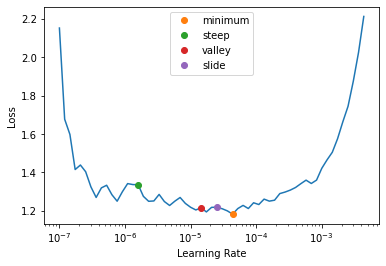

In [ ]:
# To get a good learning rate and generate a graph of mock training the model.
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
# Training the model for 4 epochs with learning rate determined by the graph above
learn.fit_one_cycle(4, lr_max=2e-4, cbs=metrics)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.814227,1.808032,0.361958,0.153636,0.256667,0.340148,0.887442,0.882798,0.885039,03:15
1,1.518016,1.956506,0.360543,0.149727,0.257250,0.336057,0.887495,0.881984,0.884652,04:19
2,0.640231,2.164851,0.354107,0.145123,0.251078,0.331283,0.886076,0.881004,0.883458,03:08
3,0.264946,2.354025,0.359958,0.149314,0.254097,0.336682,0.887613,0.882009,0.884727,03:08


As we see above, the ROUGE1 and ROUGE2 scores are not that good compared to the extractive models because the abstractive model like BART generates its own phrases to create a meaningful summary. The generated phrases may not necessarily be a part of the article which is summarized. As ROUGE scores compare the target summary with the summary generated by BART, they tend to be low. 

On the other hand, BERT score is a viable metric for evaluating the performance of abstractive models because it evaluates the semantic similarity between the tokens present in the target summary and the summary generated by BART. 

BERT score for the model when trained over only 2000 rows of data, tends to be close to 89% which is a good score compared to the ROUGE scores of extractive models. The BERT score tends to improve as we include more data and tweak the learning rate.

In [ ]:
learn.show_results(learner=learn)

,text,target,prediction
0,"While Iraq's military claimed Wednesday to have driven back militants battling for control of the country, the chairman of the Joint Chiefs of Staff told Congress that the United States has received a request from the Iraqi government to use its air power in the conflict. Gen. Martin Dempsey, the senior ranking member of the U.S. armed forces, spoke before the Senate Appropriations Committee Wednesday on Capitol Hill in Washington, saying that the United States' ""national security interest (is) to counter (ISIS) where we find them."" ISIS is the Islamic State in Iraq and Syria. Comprising mostly Sunni Muslims, ISIS is an al Qaeda splinter group that wants to establish a caliphate, or Islamic state, that would stretch from Iraq into northern Syria. The group has had substantial success in Syria battling Syrian President Bashar al-Assad's security forces. Since launching their offensive in Iraq, ISIS claims to have killed at least 1,700 Shiites. Hundreds of thousands of Iraqis have fled, prompting fears of a brewing humanitarian crisis. Qassim Atta, a spokesman for Iraqi security forces, on Wednesday night said an investigation had been ordered into 59 high-ranking security officials accused of leaving their posts. The officials could be executed if found guilty, Atta said. Concerns over","Vice President Biden stresses need for national unity in talk with Iraqi PM.\nA cleric called for attacks against U.S. embassies in the case of airstrikes.\nInvestigation will probe Iraqi security forces who left posts, general commander says.\nSaudi Arabia responds to Iraq's accusation that it's helping ISIS, calling allegation a ""falsehood""","[ Joint Chiefs of Staff chairman says U.S. has received request from Iraqi government to use air power .\nGen. Martin Dempsey says the United States wants to counter ISIS .\nIraq says 59 security officials are being investigated over, Silvio Berlusconi is seeking to win his old job again as prime minister in Italy .\nHe resigned in disgrace during a parliamentary revolt in November 2011 .\nBut recent polls suggest that there is nothing about the race now ., A wildfire is burning in Colorado near the city of Boulder .\nUse the Daily Discussion to help students understand today's featured news stories .\nThe Daily Discussion offers the weekly Newsquiz to test your knowledge of stories you saw on CNN, President Obama wants Congress to weigh in on military action in Syria .\nHe believes it is the right step to take over the alleged use of chemical weapons .\nCongress must also decide whether to authorize limited strikes in Syria, the president says]"


In [ ]:
article = r"""Jarre joins fairytale celebration

French musician Jean-Michel Jarre is to perform at a concert in Copenhagen to mark the bicentennial of the birth of writer Hans Christian Andersen. Denmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. "Christian Andersen's fairy tales are timeless and universal," said Jarre. "For all of us, at any age there is always - beyond the pure enjoyment of the tale - a message to learn." There are year-long celebrations planned across the world to celebrate Andersen and his work, which includes The Emperor's New Clothes and The Little Mermaid. Denmark's Crown Prince Frederik and Crown Princess Mary visited New York on Monday to help promote the festivities. The pair were at a Manhattan library to honour US literary critic Harold Bloom "the international icon we thought we knew so well". "Bloom recognizes the darker aspects of Andersen's authorship," Prince Frederik said. Bloom is to be formally presented with the Hans Christian Andersen Award this spring in Anderson's hometown of Odense. The royal couple also visited the Hans Christian Anderson School complex, where Queen Mary read The Ugly Duckling to the young audience. Later at a gala dinner, Danish supermodel Helena Christensen was named a Hans Christian Andersen ambassador. Other ambassadors include actors Harvey Keitel and Sir Roger Moore, athlete Cathy Freeman and Brazilian soccer legend Pele."""

expectPred = r"""Bloom is to be formally presented with the Hans Christian Andersen Award this spring in Anderson's hometown of Odense.Later at a gala dinner, Danish supermodel Helena Christensen was named a Hans Christian Andersen ambassador.French musician Jean-Michel Jarre is to perform at a concert in Copenhagen to mark the bicentennial of the birth of writer Hans Christian Andersen."Christian Andersen's fairy tales are timeless and universal," said Jarre.The royal couple also visited the Hans Christian Anderson School complex, where Queen Mary read The Ugly Duckling to the young audience."Bloom recognizes the darker aspects of Andersen's authorship," Prince Frederik said."""




In [ ]:
# Generating summary for a test article taken from BBC News Dataset

outputs = learn.blurr_generate(article, key="summary_texts", num_return_sequences=3)
outputs

[{'summary_texts': [" Denmark is celebrating the bicentennial of the birth of Hans Christian Andersen .\nA three-day celebration will include a concert at Parken stadium on 2 April .\nOther stars are expected to join the line-up in the coming months .\nDenmark's Crown Prince Frederik and Crown Princess Mary visited New York on Monday .",
   " Denmark is celebrating the bicentennial of the birth of Hans Christian Andersen .\nA three-day celebration will include a concert at Parken stadium on 2 April .\nOther stars are expected to join the line-up in the coming months .\nDenmark's Crown Prince Frederik and Crown Princess Mary visited New York to promote the festivities .",
   " Denmark is celebrating the bicentennial of the birth of Hans Christian Andersen .\nA three-day celebration will include a concert at Parken stadium on 2 April .\nOther stars are expected to join the line-up in the coming months .\nDenmark's Crown Prince Frederik and Crown Princess Mary visited the Hans Christian A

** 2 Lex Rank Algorithm **

 An extractive-based text summarization technique is the Lex Rank Algorithm. A sentence that is identical to 
numerous other sentences in the text has a high probability of being significant according to the Lex Rank algorithm. 
A sentence is ranked higher when it is suggested by other sentences that are like it. Central to this method's 
foundation is Eigen Vector. It adopts a linked graph methodology. Vertices of the graph are where sentences are 
inserted. An edge weight is determined by applying a cosine similarity metric to the edges

In [1]:
import math
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords
import numpy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# 0.23 txt from bbc_politics 

original=''' E-University 'disgraceful waste'

A failed government scheme to offer UK university courses online has been branded a "disgraceful waste" by MPs.

The e-University was scrapped last year, having attracted only 900 students at a cost of £50m. Chief executive John Beaumont was paid a bonus of £44,914, despite a failure to bring in private sector backers. The Commons education select committee called this "morally indefensible" but the government said the e-University project had "improved understanding".

A Department for Education and Skills spokeswoman said the venture had been "ambitious and ground-breaking, but take-up had not been "sufficient to continue with the project". She added: "UK e-Universities was not the only organisation to have lost out on private sector investment in the collapse of the dotcom boom." The select committee found that those responsible for founding the e-University in 2000 had been caught up in the "general atmosphere of enthusiasm" surrounding the internet. Initial business plans forecast a quarter of a million students joining within a decade, bringing in at least £110m in profit.

But virtually no market research was carried out and just £4.2m was spent on worldwide sales and marketing of courses. Some £14m went on developing the technology to make the e-University work. This was used by just 200 students, the rest preferring to work through existing university websites. With no significant private investors and no direct accountability to a government minister, the e-University had had "too much freedom to spend public money as it wished", the report found. Committee chairman Barry Sheerman said: "UK e-University was a terrible waste of public money. "The senior executives failed to interest any private investors and showed an extraordinary over-confidence in their ability to attract students to the scheme." The report warns that the government should not be scared off investment in innovative but potentially risky schemes by the failure of the e-University, but "should learn the lessons from this disaster".'''


In [3]:
threshold = 0.1
epsilon = 0.1
stopWords = set(stopwords.words("english"))
sentences = sent_tokenize(original) 
ts = len(sentences)
print(sentences)
print(ts)

[' E-University \'disgraceful waste\'\n\nA failed government scheme to offer UK university courses online has been branded a "disgraceful waste" by MPs.', 'The e-University was scrapped last year, having attracted only 900 students at a cost of £50m.', 'Chief executive John Beaumont was paid a bonus of £44,914, despite a failure to bring in private sector backers.', 'The Commons education select committee called this "morally indefensible" but the government said the e-University project had "improved understanding".', 'A Department for Education and Skills spokeswoman said the venture had been "ambitious and ground-breaking, but take-up had not been "sufficient to continue with the project".', 'She added: "UK e-Universities was not the only organisation to have lost out on private sector investment in the collapse of the dotcom boom."', 'The select committee found that those responsible for founding the e-University in 2000 had been caught up in the "general atmosphere of enthusiasm" 

In [4]:
f_mat = {}

for i in sentences:
    freq_table = {}
    words = word_tokenize(i)
    for j in words:
        j = j.lower()
        if j in stopWords:
            continue
        if j in freq_table:
            freq_table[j] += 1
        else:
            freq_table[j] = 1

    f_mat[i] = freq_table
tf_matrix = {}
counter = 0
for x, y in f_mat.items():
    tf_table = {}

    count_words_in_sentence = len(y)
    for word, count in y.items():
        tf_table[word] = count / count_words_in_sentence

    tf_matrix[counter] = tf_table
    counter = counter+1
print(tf_matrix)

{0: {'e-university': 0.05555555555555555, "'disgraceful": 0.05555555555555555, "waste'": 0.05555555555555555, 'failed': 0.05555555555555555, 'government': 0.05555555555555555, 'scheme': 0.05555555555555555, 'offer': 0.05555555555555555, 'uk': 0.05555555555555555, 'university': 0.05555555555555555, 'courses': 0.05555555555555555, 'online': 0.05555555555555555, 'branded': 0.05555555555555555, '``': 0.05555555555555555, 'disgraceful': 0.05555555555555555, 'waste': 0.05555555555555555, "''": 0.05555555555555555, 'mps': 0.05555555555555555, '.': 0.05555555555555555}, 1: {'e-university': 0.09090909090909091, 'scrapped': 0.09090909090909091, 'last': 0.09090909090909091, 'year': 0.09090909090909091, ',': 0.09090909090909091, 'attracted': 0.09090909090909091, '900': 0.09090909090909091, 'students': 0.09090909090909091, 'cost': 0.09090909090909091, '£50m': 0.09090909090909091, '.': 0.09090909090909091}, 2: {'chief': 0.06666666666666667, 'executive': 0.06666666666666667, 'john': 0.066666666666666

In [5]:
word_per_doc_table = {}

for x, y in f_mat.items():
    for word, count in y.items():
        if word in word_per_doc_table:
            word_per_doc_table[word] += 1
        else:
            word_per_doc_table[word] = 1
idf_matrix = {}
idf_table = {}
for sent, f_table in f_mat.items():

    for word in f_table.keys():
      if word not in idf_table:
        idf_table[word] = math.log10(ts / float(word_per_doc_table[word]))
      else:
        pass

    idf_matrix[sent] = idf_table
print(idf_table)

{'e-university': 0.27300127206373764, "'disgraceful": 1.1760912590556813, "waste'": 1.1760912590556813, 'failed': 0.8750612633917001, 'government': 0.5740312677277188, 'scheme': 0.8750612633917001, 'offer': 1.1760912590556813, 'uk': 0.6989700043360189, 'university': 0.8750612633917001, 'courses': 0.8750612633917001, 'online': 1.1760912590556813, 'branded': 1.1760912590556813, '``': 0.22184874961635637, 'disgraceful': 1.1760912590556813, 'waste': 0.8750612633917001, "''": 0.27300127206373764, 'mps': 1.1760912590556813, '.': 0.0, 'scrapped': 1.1760912590556813, 'last': 1.1760912590556813, 'year': 1.1760912590556813, ',': 0.3309932190414244, 'attracted': 1.1760912590556813, '900': 1.1760912590556813, 'students': 0.5740312677277188, 'cost': 1.1760912590556813, '£50m': 1.1760912590556813, 'chief': 1.1760912590556813, 'executive': 1.1760912590556813, 'john': 1.1760912590556813, 'beaumont': 1.1760912590556813, 'paid': 1.1760912590556813, 'bonus': 1.1760912590556813, '£44,914': 1.1760912590556

In [6]:
matrix = numpy.zeros((ts, ts))
print(matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
s = {}
for i in range(ts):
  s[i]=sentences[i]
stop_words = set(stopwords.words("english"))
for i in range(ts):
  for j in range(ts):
    u1 = word_tokenize(s[i]) 
    u1 = [word for word in u1 if word.isalpha()]
    u1 = [word for word in u1 if word not in stop_words]
    u1 = [element.lower() for element in u1]
    u2 = word_tokenize(s[j]) 
    u2 = [word for word in u2 if word.isalpha()]
    u2 = [word for word in u2 if word not in stop_words]
    u2 = [element.lower() for element in u2]
    common = list(set(u1) & set(u2))
    d1=0
    d2=0
    n=0.0
    for t in u1:
      if t in tf_matrix[i]:
        tf1=tf_matrix[i][t]
      else:
        tf1=0
      if t in idf_table:
        idf1=idf_table[t]
      else:
        idf1=0
      d1+=(tf1*idf1)**2
    for t in u2:
      if t in tf_matrix[j]:
        tf2=tf_matrix[j][t]
      else:
        tf2=0
      if t in idf_table:
        idf2=idf_table[t]
      else:
        idf2=0
      d2+=(tf2*idf2)**2
    for t in common:
      if t in tf_matrix[i]:
        tfc1=tf_matrix[i][t]
      else:
        tfc1=0
      if t in tf_matrix[j]:
        tfc2=tf_matrix[j][t]
      else:
        tfc2=0
      if t in idf_table:
        idf=idf_table[t]
      else:
        idf=0
      n+=tfc1*tfc2*idf**2
    if d1 > 0 and d2 > 0:
      matrix[i][j] =  n / (math.sqrt(d1) * math.sqrt(d2))
    else:
      matrix[i][j] = 0.0
print(matrix)

[[1.         0.         0.         0.02808756 0.         0.0440291
  0.         0.         0.06546846 0.         0.07601097 0.0245715
  0.12098443 0.12668607 0.02495784]
 [0.         1.         0.         0.         0.         0.
  0.         0.02975348 0.         0.         0.0413206  0.
  0.         0.03443414 0.        ]
 [0.         0.         1.         0.         0.         0.08872539
  0.         0.         0.         0.         0.         0.02208747
  0.         0.02450232 0.05213471]
 [0.02808756 0.         0.         1.         0.17115597 0.
  0.10050201 0.         0.         0.         0.         0.02421773
  0.09289232 0.         0.0245985 ]
 [0.         0.         0.         0.17115597 1.         0.
  0.         0.         0.         0.         0.         0.
  0.04684258 0.         0.        ]
 [0.0440291  0.         0.08872539 0.         0.         1.
  0.         0.         0.         0.         0.         0.02560432
  0.04910544 0.02840367 0.0604358 ]
 [0.         0.   

In [8]:
degrees = numpy.zeros((ts, ))
for i in range(ts):
  for j in range(ts):
    if matrix[i, j] > threshold:
      matrix[i, j] = 1.0
      degrees[i] += 1
    else:
      matrix[i, j] = 0
print(matrix)
print(degrees)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[3. 1. 1. 3. 2. 1. 2. 1. 1. 2. 2. 2. 3. 2. 1.]


In [9]:
for i in range(ts):
    for j in range(ts):
        if degrees[i] == 0:
            degrees[i] = 1

        matrix[i][j] = matrix[i][j] / degrees[i]
print(matrix)

[[0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.33333333 0.33333333 0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.5        0.5        0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.

In [10]:
transposed_matrix = matrix.T

p_vector = numpy.array([1.0 / ts] * ts)

lamb = 1.0

while lamb > epsilon:
  next_p = numpy.dot(transposed_matrix, p_vector)
  lamb = numpy.linalg.norm(numpy.subtract(next_p, p_vector))
  p_vector = next_p
print(p_vector)

[0.07777778 0.06666667 0.06666667 0.08888889 0.05555556 0.06666667
 0.05555556 0.06666667 0.06666667 0.06666667 0.06666667 0.05555556
 0.07777778 0.05555556 0.06666667]


In [11]:
avg = numpy.sum(p_vector) / len(p_vector)
print(avg)

0.06666666666666667


In [12]:
for i in range(ts):
  if(p_vector[i]>=avg):
    print(s[i])

 E-University 'disgraceful waste'

A failed government scheme to offer UK university courses online has been branded a "disgraceful waste" by MPs.
The e-University was scrapped last year, having attracted only 900 students at a cost of £50m.
Chief executive John Beaumont was paid a bonus of £44,914, despite a failure to bring in private sector backers.
The Commons education select committee called this "morally indefensible" but the government said the e-University project had "improved understanding".
She added: "UK e-Universities was not the only organisation to have lost out on private sector investment in the collapse of the dotcom boom."
Initial business plans forecast a quarter of a million students joining within a decade, bringing in at least £110m in profit.
But virtually no market research was carried out and just £4.2m was spent on worldwide sales and marketing of courses.
Some £14m went on developing the technology to make the e-University work.
This was used by just 200 st

In [13]:
pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.7 MB/s 
     |████████████████████████████████| 10.1 MB 29.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21714 sha256=680df962b8f186159dea7d63fcf277ae78a53d53a98c37d8c6e3802c67fb362e
  Stored in directory: /root/.cache/pip/wheels/5f/0d/0c/2062d8c1758b4b1a2e42b4a63e6660d9ec2ba9463cfee9eeab
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=da3c0a16bdaeb5572e8ca6fda3bc943d9f824c85f987b530126ad7e8b112f5c6
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=92ee39737b809a8e20bdab22de

In [14]:
import numpy as np
import os

import sumy
from textblob import TextBlob
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.models.dom import Sentence
from sumy.evaluation.rouge import rouge_1,rouge_2

In [15]:
ref = original
reference  = []
for i in ref:
  reference.append(Sentence(i,Tokenizer('english')))


In [17]:
lines=[]
with open("023.txt", "r") as tm:
	lines = tm.readlines()
	print(lines)

['Committee chairman Barry Sheerman said: "UK e-University was a terrible waste of public money.The e-University was scrapped last year, having attracted only 900 students at a cost of £50m.The Commons education select committee called this "morally indefensible" but the government said the e-University project had "improved understanding".With no significant private investors and no direct accountability to a government minister, the e-University had had "too much freedom to spend public money as it wished", the report found.The report warns that the government should not be scared off investment in innovative but potentially risky schemes by the failure of the e-University, but "should learn the lessons from this disaster".She added: "UK e-Universities was not the only organisation to have lost out on private sector investment in the collapse of the dotcom boom."']


In [18]:
given_sum=[]
for i in lines:
  given_sum.append(Sentence(i,Tokenizer('english')))
final=[]
summary = ' '.join(list(s.values())[:5])
for i in summary:
  final.append(Sentence(i,Tokenizer('english')))
given_sum=reference
print(rouge_1(final,reference))

0.9230769230769231


3. Text Rank Algorithm

TextRank is an algorithm based on PageRank, which often used in keyword extraction and text summarization

In [19]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sumy.evaluation.rouge import rouge_1, rouge_2
from sumy.models.dom import Sentence
from sumy.nlp.tokenizers import Tokenizer
import zipfile
import string
import os
from nltk.tokenize import sent_tokenize

with zipfile.ZipFile('bbc-news-summary.zip', 'r') as zip_ref:
    zip_ref.extractall('')
    
nltk.download('punkt')

politics_texts=os.listdir('bbc news summary/BBC News Summary/News Articles/politics')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
sentences = []
root='bbc news summary/BBC News Summary/News Articles/politics'

file_name = politics_texts[0]
file_ = open(root+'/'+file_name, "r") 

politics_file = file_.read().replace('\n', '.')
politics_file = politics_file.split('.')

for idx, sent in enumerate(politics_file):
  if sent!='':
        if sent[0].isdigit():
          sentences[-1][0]+=sent_tokenize(sent)[0]
        else:
          sentences.append(sent_tokenize(sent))
          
print(sentences)

[['Tsunami debt deal to be announced'], ['Chancellor Gordon Brown has said he hopes to announce a deal to suspend debt interest repayments by tsunami-hit nations later on Friday'], ['The agreement by the G8 group of wealthy nations would save affected countries £3bn pounds a year, he said'], [' The deal is thought to have been hammered out on Thursday night after Japan, one of the biggest creditor nations, finally signed up to it'], [' Mr Brown first proposed the idea earlier this week'], ['G8 ministers are also believed to have agreed to instruct the World Bank and the International Monetary Fund to complete a country by country analysis of the reconstruction problems faced by all states hit by the disaster'], [' Mr Brown has been locked in talks with finance ministers of the G8, which Britain now chairs'], [' Germany also proposed a freeze and Canada has begun its own moratorium'], [' The expected deal comes as Foreign Secretary Jack Straw said the number of Britons dead or missing i

In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-12-12 02:57:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-12 02:57:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-12 02:57:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [22]:
stop_words = set(stopwords.words('english') + list(string.punctuation))

In [24]:
def remove_stopwords(sentence):
    sen_new = " ".join([sent for sent in sentence if sent.lower() not in stop_words])
    return sen_new

In [25]:
import re

clean_sentences = []
idx=0

while idx < len(sentences):
  sent = sentences[idx]
  regex = re.compile('[^a-zA-Z]')
  if len(sent)!=0:
    clean_sentences.append(regex.sub(' ', sent[0]))
    idx+=1
  else:
    del sentences[idx]

clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

print(clean_sentences)

['Tsunami debt deal announced', 'Chancellor Gordon Brown said hopes announce deal suspend debt interest repayments tsunami hit nations later Friday', 'agreement G group wealthy nations would save affected countries bn pounds year said', 'deal thought hammered Thursday night Japan one biggest creditor nations finally signed', 'Mr Brown first proposed idea earlier week', 'G ministers also believed agreed instruct World Bank International Monetary Fund complete country country analysis reconstruction problems faced states hit disaster', 'Mr Brown locked talks finance ministers G Britain chairs', 'Germany also proposed freeze Canada begun moratorium', 'expected deal comes Foreign Secretary Jack Straw said number Britons dead missing disaster reached']


In [26]:
import numpy as np

word_embeddings = {}

f = open('glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()

    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')

    word_embeddings[word] = coefs

f.close()

In [27]:
politics_words={}
for sent in clean_sentences:
  if len(sent)!=0:        
    for w in sent.split():
      if w not in politics_words:
        politics_words[w]=1
      else:
        politics_words[w]+=1
        
ps_words = pd.DataFrame.from_dict({'words':list(politics_words.keys()),'counts':list(politics_words.values()) })
ps_words = ps_words.set_index('words')

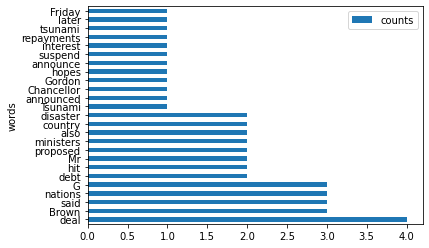

In [28]:
top_twenty_five=ps_words.nlargest(25, ['counts'])
ax = top_twenty_five.plot.barh(x=None, y='counts', rot=0)

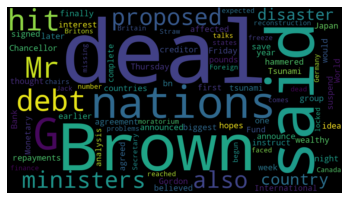

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(politics_words)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
sentence_vectors = []

offset = 0.001

for sent in clean_sentences:
  if len(sent) != 0:
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in sent.split()])/(len(sent.split()) + offset )
  else:
    v = np.zeros((100,))
  sentence_vectors.append(np.array(v))
sentence_vectors=np.array(sentence_vectors)

In [31]:
def cos_similarity(mat):
  norm = (mat.T * mat.T).sum(0, keepdims=True) ** .5
  return (mat @ mat.T ) / norm.T / norm 

cos_mat = cos_similarity(sentence_vectors)

In [32]:
from scipy import sparse

cos_mat[cos_mat < 0.9]=0

for i in range(len(sentences)):
  cos_mat[i,i] = 0

cos_mat[np.isnan(cos_mat)] =0

sparse_mat = sparse.csr_matrix(cos_mat)

sparse_mat.eliminate_zeros()

In [39]:
!python ‐‐version

python3: can't open file '‐‐version': [Errno 2] No such file or directory


In [44]:
import networkx as nx 
SimilarityGraph = nx.from_scipy_sparse_matrix(sparse_mat)

scores = nx.pagerank(SimilarityGraph)
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

summary = []
for i in range(5):
      summary.append(ranked_sentences[i][1][0])

print(" ".join(summary))

 He will be known Baron Kinnock of Bedwellty - after his former constituency Former Labour leader Neil Kinnock has officially been made a life peer during a ceremony in the House of Lords Baron Kinnock makes Lords debut After a brief career as a tutor for the Workers' Educational Association, he became an MP at the age of just 28 for his home seat of Bedwellty (later Islwyn) " During his induction into the Upper House, Lord Kinnock was accompanied by Lords Leader Baroness Amos and Baroness Royall of Blaisdon, a former aide to the ex-Labour leader
/var/folders/4_/23jd91ms6716tnh9dwmmcc2c0000gn/T/ipykernel_14351/3761564870.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  SimilarityGraph = nx.from_scipy_sparse_matrix(sparse_mat)


In [43]:
summary_text = 'bbc news summary/BBC News Summary/Summaries/politics'
summary_file_ = open(root+'/'+file_name, "r")
summary_file_.read().replace('\n', '.')

generated_summary = " ".join(summary)

summary_arr = []
generated_summary_arr = []

for txt in summary_text:
    summary_arr.append(Sentence(txt,Tokenizer('english')))
    
for txt in generated_summary: 
    generated_summary_arr.append(Sentence(txt, Tokenizer('english')))

print("Rouge 1 scores textRank: ", rouge_1(generated_summary_arr, summary_arr))



Rouge 1 scores textRank:  0.95
